Required installation ⚙

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

In [ ]:
!pip install tensorflow-datasets

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


libraries

In [161]:
# Importing libraries

import pandas as pd
import numpy as np
from numpy import float32
from tqdm import tqdm
import math

from typing import Optional
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, confusion_matrix, precision_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.multiprocessing import set_start_method

import pytorch_lightning as pl

from torch.utils.data import DataLoader, Dataset
import os

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from google.colab import files
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable

In [ ]:
tfds.list_builders()

#Prepare the dataset

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Study_UCI/GAN/data/creditcard.csv', sep=',')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [14]:
# Removing non PCA column for ease of preparation.
df_lean = df.drop(['Time','Amount'],axis=1)
# Creating function to plot confusion metrics for evaluation
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [19]:
random_seed = 123
torch.manual_seed(random_seed)

BATCH_SIZE=1000
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

training a model with real data

In [15]:
train, test = train_test_split(df_lean, test_size=0.2, stratify=df['Class'])
train.shape, test.shape

((227845, 29), (56962, 29))

In [16]:
# Normalizing the data
data_mean = train.iloc[:,:-1].mean()
data_std = train.iloc[:,:-1].std()
train_norm = (train.iloc[:,:-1] - data_mean)/data_std
test_norm = (test.iloc[:,:-1] - data_mean)/data_std
train_norm['Class'] =  train.iloc[:, -1]
test_norm['Class'] =  test.iloc[:, -1]

In [17]:
train_norm['Class'].value_counts()

0    227451
1       394
Name: Class, dtype: int64

model & function

In [20]:
# Creating data model to use with the pytorch Lightning package
class CreditCardDataFinal(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = torch.tensor(self.data[index][-1], dtype=torch.float32)
        row = torch.tensor(self.data[index][:-1], dtype=torch.float32)
        return row, label

class CreditCardDataModel(pl.LightningDataModule):
    def __init__(self, data: pd.DataFrame, batch_size=BATCH_SIZE, num_workers=0):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage: Optional[str] = None):
        train_df, test_df = train_test_split(self.data, random_state=123, test_size=0.2, stratify=self.data['Class'])
        self.train_df = torch.tensor(train_norm.to_numpy(float32), dtype=torch.float32)
        self.test_df = torch.tensor(test_norm.to_numpy(float32), dtype=torch.float32)

    def train_dataloader(self):
        return DataLoader(dataset=CreditCardDataFinal(self.train_df), batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=CreditCardDataFinal(self.test_df), batch_size=self.batch_size, num_workers=self.num_workers)

In [21]:
# Building the main neural network to predict if the data is fraud or not.
class ModelCreditCard(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 150),
            nn.LeakyReLU(0.1),
            nn.Linear(150, 50),
            nn.LeakyReLU(0.1),
            nn.Linear(50, 25),
            nn.LeakyReLU(0.1),
            nn.Linear(25, 1)
        )

    def forward(self, x):
        tensor = torch.sigmoid(self.sequential(x))
        return tensor


class ModelTraining(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = model


    def training_step(self, batch, batch_idx):
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        y_hat = self.model(x)
        y = y.unsqueeze(1)
        loss = self.binary_loss(y_hat, y)
        return {"loss":loss}

    def binary_loss(self, y_hat,y):
        return F.binary_cross_entropy(y_hat, y)

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.model.parameters(), lr )
        return [opt_g], []

In [22]:
#train model
model_card = ModelCreditCard(28)
model = ModelTraining(model_card)

data = CreditCardDataModel(train_norm)
('train data shape', len(data))
#trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1)
#trainer.fit(model, data)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type            | Params
------------------------------------------
0 | model | ModelCreditCard | 13.2 K
------------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size

Training: |          | 0/? [00:00<?, ?it/s]

<ipython-input-20-df7ae187be78>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.data[index][-1], dtype=torch.float32)
<ipython-input-20-df7ae187be78>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  row = torch.tensor(self.data[index][:-1], dtype=torch.float32)
<ipython-input-21-1b48dcc11f0c>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
<ipython-input-21-1b48dcc11f0c>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().de

In [36]:
#test model accuracy
test_pred = torch.tensor(test_norm.drop(["Class"], axis=1).to_numpy()).float()
test_true =  test_norm['Class'].to_numpy()

print('test data length',test_pred.shape)
test_true = torch.tensor(test_true).unsqueeze(1).float()

test data length torch.Size([56962, 28])


In [38]:
test_output_real = model_card.forward(test_pred)
test_pred_real = [1 if i > 0.5 else 0 for i in test_output_real]
print('baseline recall',recall_score(test_true, test_pred_real))
#accuracy score
print('baseline accuracy',accuracy_score(test_pred_real,test_true))

baseline recall 0.6530612244897959
baseline accuracy 0.9992451107756047


Produce Synthetic Data

In [164]:
class CreditCardData(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = torch.tensor(self.data.iloc[index]).float()
        return row

In [186]:
class DataModule(pl.LightningDataModule):
    def __init__(self, data: pd.DataFrame, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        """
        Empty prepare_data method left in intentionally.
        https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html#prepare-data
        """
        pass

    def setup(self, stage: Optional[str] = None):
        train_df, test_df = train_test_split(self.data, random_state=123, test_size=0.2)
        data_mean = train_df.mean()
        data_std = train_df.std()
        train_norm = (train_df - data_mean)/data_std
        test_norm = (test_df - data_mean)/data_std
        self.train_df = train_norm
        self.test_df = test_norm

    def train_dataloader(self):
        return DataLoader(dataset=CreditCardData(self.train_df), batch_size=self.batch_size, num_workers=self.num_workers)

    def valid_dataloader(self):
        return DataLoader(CreditCardData(self.val_df), batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(CreditCardData(self.test_df), batch_size=self.batch_size, num_workers=self.num_workers)

In [212]:
only_pos = train_norm[train_norm['Class'] == 1 ].copy()
only_pos = only_pos.drop(['Class'], axis=1)
only_pos=only_pos[0:384]
only_pos.shape

(384, 28)

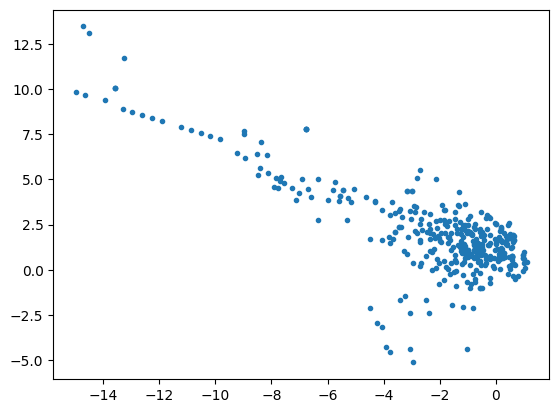

torch.Size([384, 28])


In [213]:
#preapre training data
#train_data_length = 1024
#train_data = torch.zeros((train_data_length, 2))
train_data=torch.tensor(only_pos.values, dtype=torch.float32)
train_data_length=len(only_pos)
train_labels = torch.ones(train_data.size(0), dtype=torch.float32)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

#plot training data
plt.plot(train_data[:, 0], train_data[:, 1], ".")
plt.savefig('train_data.png')
plt.show()

batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
print(train_data.shape)

In [ ]:
#Implement the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

#calling the discriminator
discriminator = Discriminator()

#Generator Modeling
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 28),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

#initiate hyper- parameters
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        print(output_discriminator.shape)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")


#plot generated samples
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.savefig('generated_data.png')
plt.show()

In [217]:
column_names = only_pos.columns
generated_df = pd.DataFrame(generated_samples.detach().numpy(), columns=column_names)
generated_df['Class'] = 1
only_neg_real_df = train_norm[train_norm['Class'] == 0]

In [219]:
train_combined_fake_pos_only = generated_df
only_neg_real_df = train_norm[train_norm['Class'] == 0]
train_combined_fake_pos_only.columns = only_neg_real_df.columns
train_combined_fake_pos_only = train_combined_fake_pos_only.append(only_neg_real_df)
train_combined_fake_pos_only = train_combined_fake_pos_only.sample(frac=1) # Shuffle the dataset

<ipython-input-219-7a30a8c8a075>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_combined_fake_pos_only = train_combined_fake_pos_only.append(only_neg_real_df)


Model Performance with GAN synthetic data

In [ ]:
model_card_with_gan = ModelCreditCard(28)
model_gan = ModelTraining(model_card_with_gan)
dm_only_gan = CreditCardDataModel(train_combined_fake_pos_only)
trainer = pl.Trainer(max_epochs=10, accelerator='cuda', devices=1)
trainer.fit(model_gan, dm_only_gan)

In [222]:
test_output_gan = model_card_with_gan.forward(test_pred)
test_pred_gan = [1 if i > 0.5 else 0 for i in test_output_gan]
#recall_score(test_true, test_pred_gan)

In [224]:
print('baseline recall',recall_score(test_true, test_pred_gan))
#accuracy score
print('baseline accuracy',accuracy_score(test_pred_gan,test_true))

baseline recall 0.6836734693877551
baseline accuracy 0.9992451107756047
